In [64]:
from keras import Input
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [65]:
IMAGE_SIZE = [224, 224]

In [66]:
images_path = '../../../../../mnt/e/datasets/cor'
train_path = images_path+'/train'
test_path = images_path+'/test'

In [67]:
def get_filenames_from_folder(folder:str):
    '''
    Returns all filenames in a directory tree
    '''
    file_list = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            file_list.append(os.path.join(root,file).replace('\\','/'))
    return file_list

In [68]:
folder = train_path+'/normal'

normal_files = get_filenames_from_folder(folder)
rain_files = get_filenames_from_folder(train_path+'/rain')
print(f"{len(normal_files)} images of normal situation")
print(f"{len(rain_files)} images of rain")


17751 images of normal situation
47155 images of rain


In [69]:
folders = glob(train_path+'/*')
print(len(folders))

2


In [70]:
def vgg16_predictions(image_size, activation_func='softmax'):
  vgg = VGG16(input_shape=image_size, weights='imagenet')
  for layer in vgg.layers:
    layer.trainable = False
  new_predictions = Dense(len(folders), activation=activation_func)(vgg.layers[21].output)
  model = Model(inputs=vgg.input, outputs=new_predictions)
  # model.layers[22]._name = 'new_predictions'
  for layer in model.layers:
      layer.trainable = False
  model.layers[-1].trainable = True
  return model



In [71]:
def vgg16_dense(image_size, activation_func='softmax'):
    vgg = VGG16(input_shape=image_size, weights='imagenet', include_top=False)
    for layer in vgg.layers:
        layer.trainable = False
    x = Flatten()(vgg.output)
    prediction = Dense(len(folders), activation=activation_func)(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    return model

In [72]:
def choose_vgg16(type:str = 'dense', activation_func:str='softmax'):
    if type == 'dense':
        return vgg16_dense(IMAGE_SIZE + [3], activation_func)
    elif type == 'predictions':
        return vgg16_predictions((IMAGE_SIZE[0], IMAGE_SIZE[1],3), activation_func)

In [73]:
choice = 'dense'
activation_func = 'softmax'
model = choose_vgg16(choice, activation_func)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [74]:
model.layers[-1].trainable = True
model.layers[-2].trainable = True

In [75]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [76]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# test_datagen = ImageDataGenerator()

In [77]:
batch_size = 32

train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 64906 images belonging to 2 classes.


In [78]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

Found 7492 images belonging to 2 classes.


In [79]:
import datetime
from pytz import timezone
def current_time():
    return datetime.now(timezone("Brazil/East")).strftime("%Y-%m-%d_%H-%M-%S")

In [80]:
from keras import optimizers
from keras import metrics

metric = metrics.MeanIoU(len(folders)) # Intersection-over-union a.k.a. Jaccard Index
classification_losses = [
    'binary_crossentropy',
    'hinge',
    'squared_hinge'
                         ]
loss = classification_losses[0]

adam = optimizers.Adam()
model.compile(loss=loss,
              optimizer=adam,
              metrics=metric)

In [81]:
EPOCH_LR_PATIENCE = 10
def scheduler(epoch:int, learning_rate):
    if epoch > 10 and epoch % EPOCH_LR_PATIENCE == 0:
        return learning_rate/10
    return learning_rate

In [82]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

monitor = "val_loss"
patience = 30
verbose = 2
# steps_epoch = test_set.__len__()
steps_epoch = train_set.__len__()/batch_size


model_name = f'{current_time()}_vgg_{choice}_{activation_func}_loss{loss}_batch{batch_size}_steps{int(steps_epoch)}'
model_folder = f'models/{model_name}'

if not os.path.exists(model_folder):
  os.makedirs(model_folder)
            
file_path = f'{model_folder}/{model_name}'

checkpoint = ModelCheckpoint(filepath=file_path+"_{epoch:02d}.h5", 
                             monitor=monitor, 
                             verbose=verbose, 
                             save_best_only=False, 
                             save_freq='epoch',
                             period=5)
es = EarlyStopping(monitor=monitor,
                         patience=patience,
                         verbose=verbose,
                         mode='min',
                         restore_best_weights=True)
lrs = LearningRateScheduler(scheduler)
callbacks = [es, 
             lrs, 
             checkpoint]

start = datetime.now()

model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=steps_epoch,
  # validation_steps=32,
  callbacks=callbacks,
  verbose=2)

duration = datetime.now() - start
print("Training completed in time: ", duration)

/tmp/ipykernel_706/1025580221.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=model.fit_generator(


Epoch 1/100


2023-07-23 15:45:39.721142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-23 15:46:24.383244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


63/63 - 103s - loss: 1.4261 - mean_io_u_3: 0.7961 - val_loss: 0.4097 - val_mean_io_u_3: 0.8689 - lr: 0.0010 - 103s/epoch - 2s/step
Epoch 2/100
63/63 - 100s - loss: 0.9231 - mean_io_u_3: 0.8779 - val_loss: 1.4867 - val_mean_io_u_3: 0.7521 - lr: 0.0010 - 100s/epoch - 2s/step
Epoch 3/100
63/63 - 103s - loss: 0.7270 - mean_io_u_3: 0.9162 - val_loss: 2.1636 - val_mean_io_u_3: 0.8301 - lr: 0.0010 - 103s/epoch - 2s/step
Epoch 4/100
63/63 - 103s - loss: 0.6838 - mean_io_u_3: 0.9158 - val_loss: 1.9718 - val_mean_io_u_3: 0.7906 - lr: 0.0010 - 103s/epoch - 2s/step
Epoch 5/100

Epoch 5: saving model to models/2023-07-23_15-45-38_vgg_dense_softmax_lossbinary_crossentropy_batch32_steps63/2023-07-23_15-45-38_vgg_dense_softmax_lossbinary_crossentropy_batch32_steps63_05.h5
63/63 - 100s - loss: 0.7043 - mean_io_u_3: 0.9284 - val_loss: 1.5348 - val_mean_io_u_3: 0.8652 - lr: 0.0010 - 100s/epoch - 2s/step
Epoch 6/100
63/63 - 98s - loss: 0.5278 - mean_io_u_3: 0.9389 - val_loss: 1.6475 - val_mean_io_u_3: 0.8

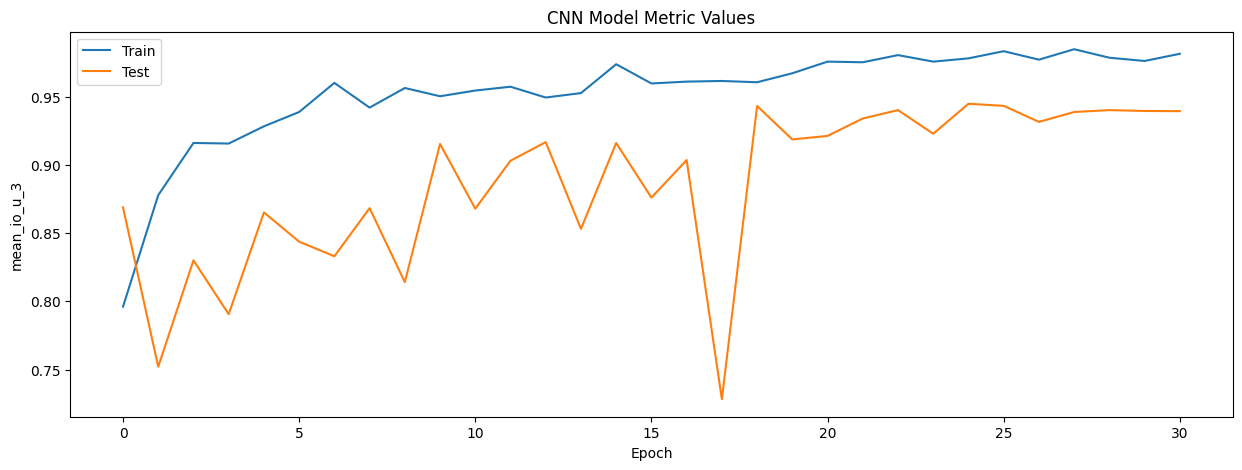

In [84]:
# Plot training & validation metric values
plt.figure(figsize=(15,5))
plt.plot(model_history.history[metric.name])
plt.plot(model_history.history['val_'+metric.name])
plt.title('CNN Model Metric Values')
plt.ylabel(metric.name)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plot_folder = f'models/{model_name}/plot'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

plt.savefig(f'{plot_folder}/{metric.name}.png')
plt.show()